In [1]:
import os
from utils.configuration import *
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "api_ordinal_multi_simple_4"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/configuration.json


In [4]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import make_classification

# # Generate synthetic data for logistic regression
# X, y = make_classification(
#     n_samples=100_000,      # number of samples
#     n_features=1,       # one predictor
#     n_informative=1,    # the predictor is informative
#     n_redundant=0,      # no redundant features
#     n_clusters_per_class=3,
#     class_sep=1.5,      # separation between classes
#     weights=[0.9, 0.1],  # 90% class 0, 10% class 1
#     random_state=42
# )

# # Convert to DataFrame for convenience
# df = pd.DataFrame({'x': X.flatten(), 'y': y})

# # Save or inspect
# print(df.head())


import numpy as np
import pandas as pd

# Generate one continuous predictor
n = 100_000
x = np.random.normal(0, 1, n)
x1 = np.random.normal(2, 4, n)
x2 = np.random.normal(-1, 1, n)
x3 = np.random.normal(3, 0.1, n)

# Define thresholds for 4 ordered levels
thresholds = [-0.8, 0.0, 0.8]

# Digitize x into 4 ordinal levels (0,1,2,3)
y = np.digitize(x, thresholds)

# Combine into DataFrame
df = pd.DataFrame({'x': x,'x1': x1,'x2': x2,'x3': x3, 'y': y})

print(df.head())
print(df['y'].value_counts(normalize=True))


          x        x1        x2        x3  y
0  0.735001  2.952773 -2.058358  2.994855  2
1  1.124451 -7.185875 -2.023281  2.973567  3
2  1.602489  1.157310  0.026492  3.090493  3
3 -0.549940  1.077340 -0.177586  2.990135  1
4 -0.119138  0.885541  0.786204  3.136256  1
y
2    0.29099
1    0.28698
3    0.21119
0    0.21084
Name: proportion, dtype: float64


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
data_type={'x':'continous','x1':'continous','x2':'continous','x3':'continous','y':'ordinal_Xn_Yo'}
data_type

{'x': 'continous',
 'x1': 'continous',
 'x2': 'continous',
 'x3': 'continous',
 'y': 'ordinal_Xn_Yo'}

In [7]:
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x                    | continous       | continuous [c]                 | continuous [c]                
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | continous       | continuous [c]                 | continuous [c]                
y                    | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


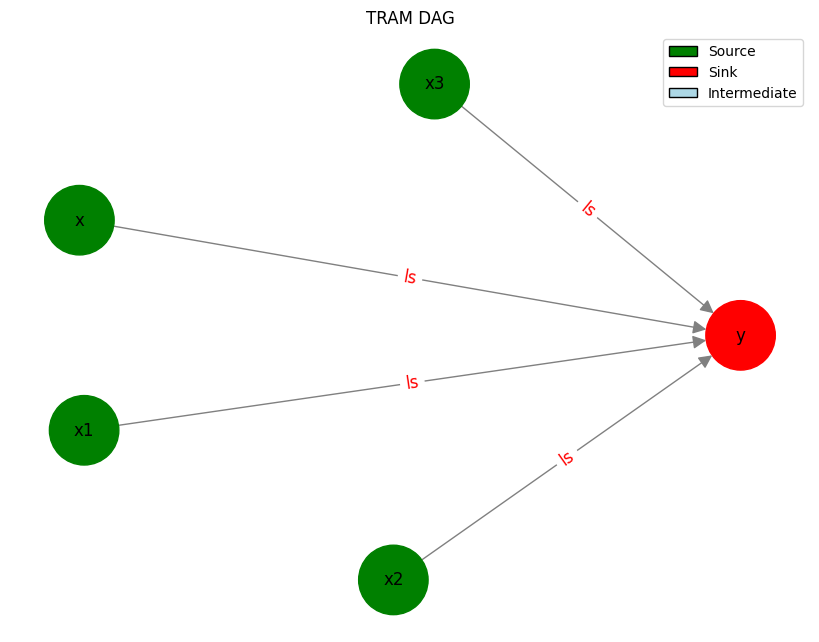

In [8]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

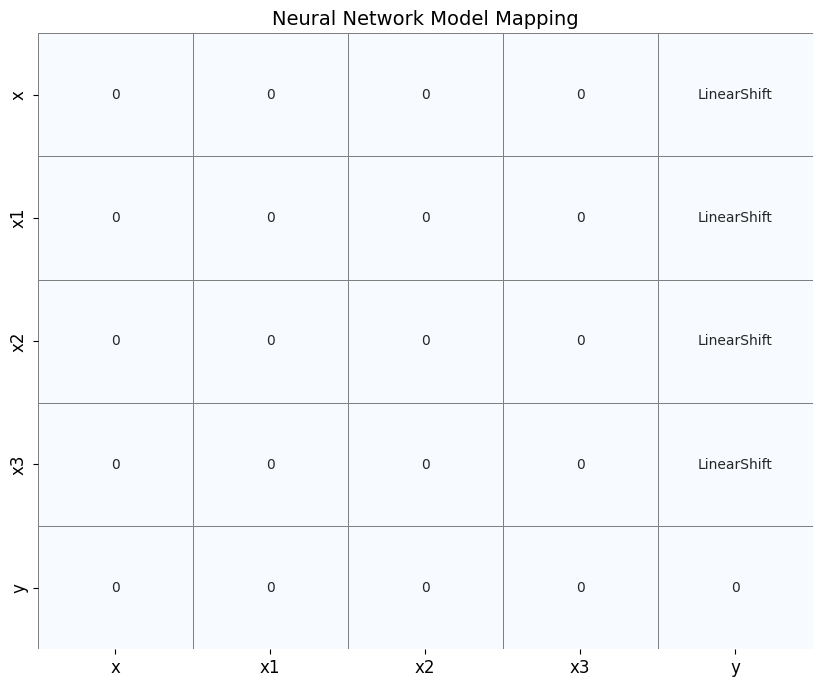

In [9]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [10]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load(f"/home/bule/TramDag/dev_experiment_logs/{experiment_name}/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [11]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':               x        x1        x2        x3  y
75220 -0.737612  5.903782 -0.906521  3.182245  1
48955  0.106192  7.800717 -0.255483  2.944750  2
44966 -1.036408 -3.013836 -2.099330  3.069236  0
13568  0.739038  3.146609 -0.481959  3.007452  2
92727 -0.521661  5.059411  0.520690  3.017906  1
...         ...       ...       ...       ... ..
6265   1.224924  8.311885 -0.537249  2.995585  3
54886  0.263654  8.557227 -0.458235  3.059859  2
76820 -0.446694  4.054049 -0.691939  3.108732  1
860    1.013220  5.011135 -2.987500  3.028711  3
15795  1.945252  5.330673 -1.113034  2.925315  3

[80000 rows x 5 columns]}
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20

[INFO] Building model for node 'x1' with settings: {'set_initial_weights': False, 'deb

In [12]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=500,batch_size=1_000,
             verbose=True,debug=False,
             device=device,
             save_linear_shifts=True,
             save_simple_intercepts=True,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/min_max_scaling.json
[INFO] Training 5 nodes (sequential) on cpu

[INFO] Training node 'x' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x1' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x2' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x3' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'y' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...


[INFO] Loaded training/validation histories for 5 nodes.


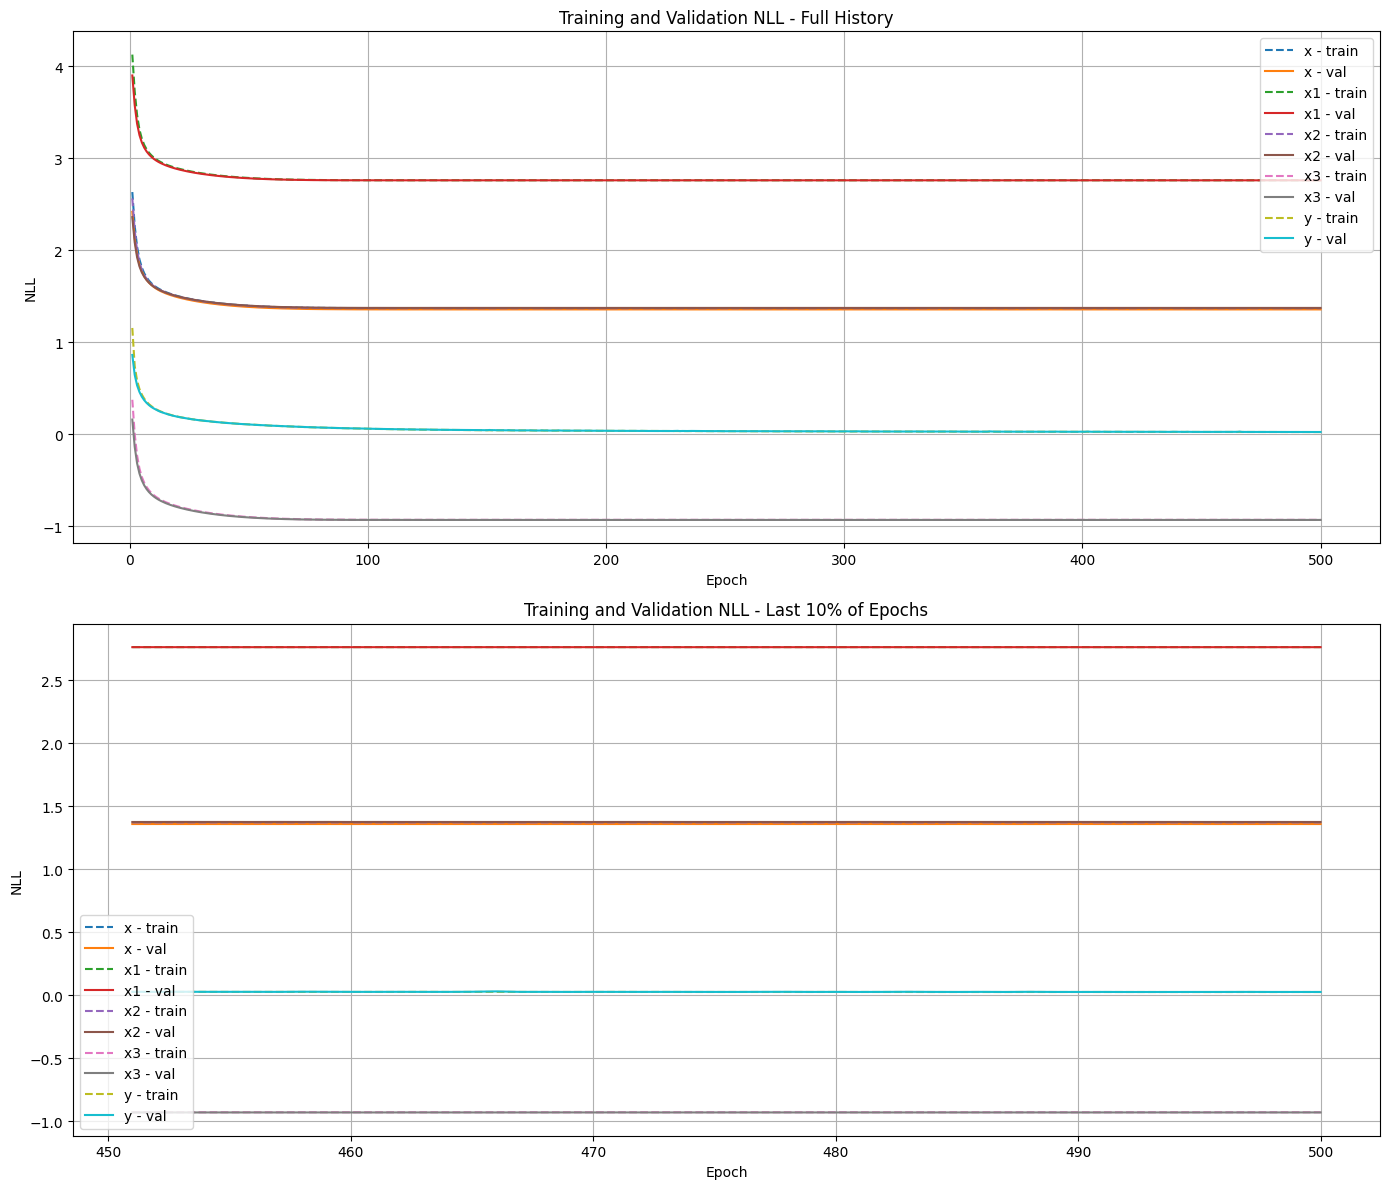

In [13]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x1/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x2' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x2/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x3' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x3/linear_shifts_all_epochs.json


/home/bule/TramDag/utils/tramdag.py:1569: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


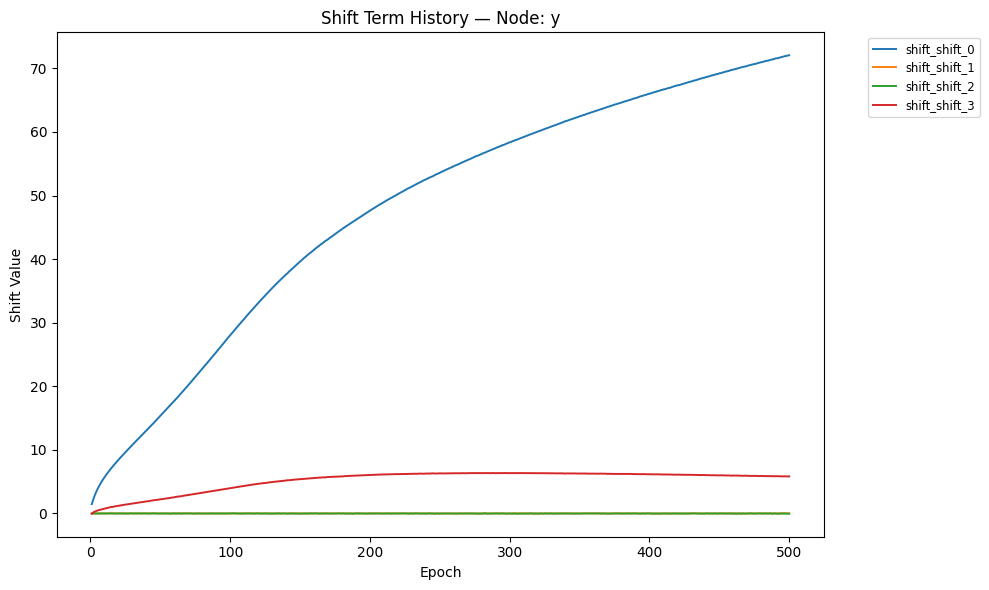

In [14]:
td_model.plot_shift_histories()

/home/bule/TramDag/utils/tramdag.py:1618: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


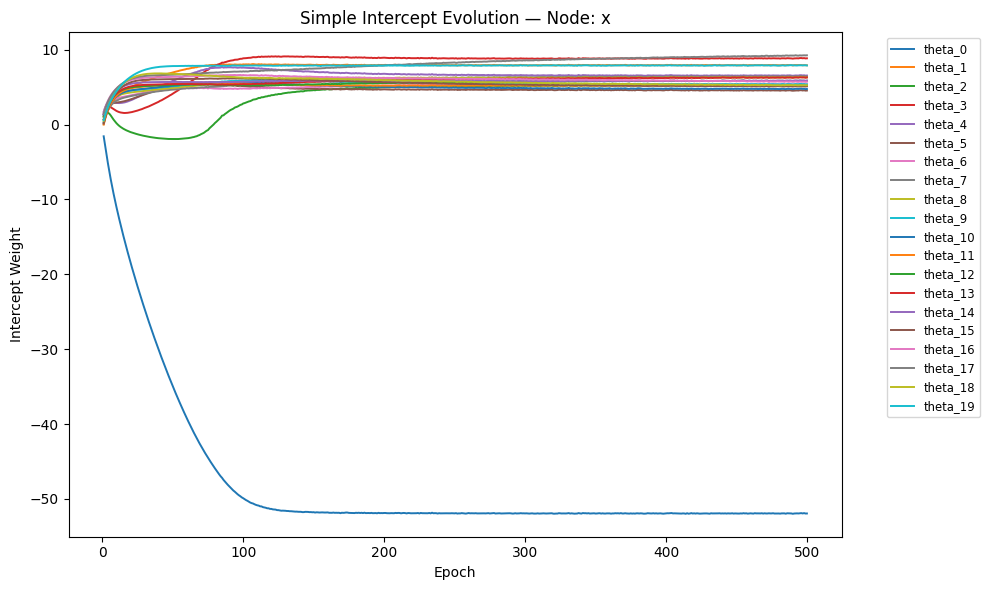

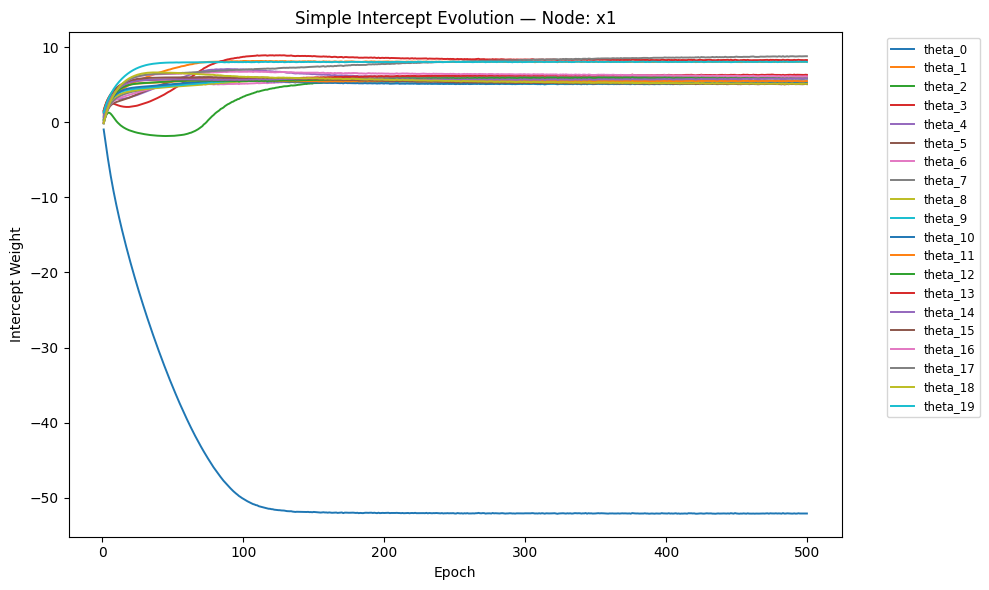

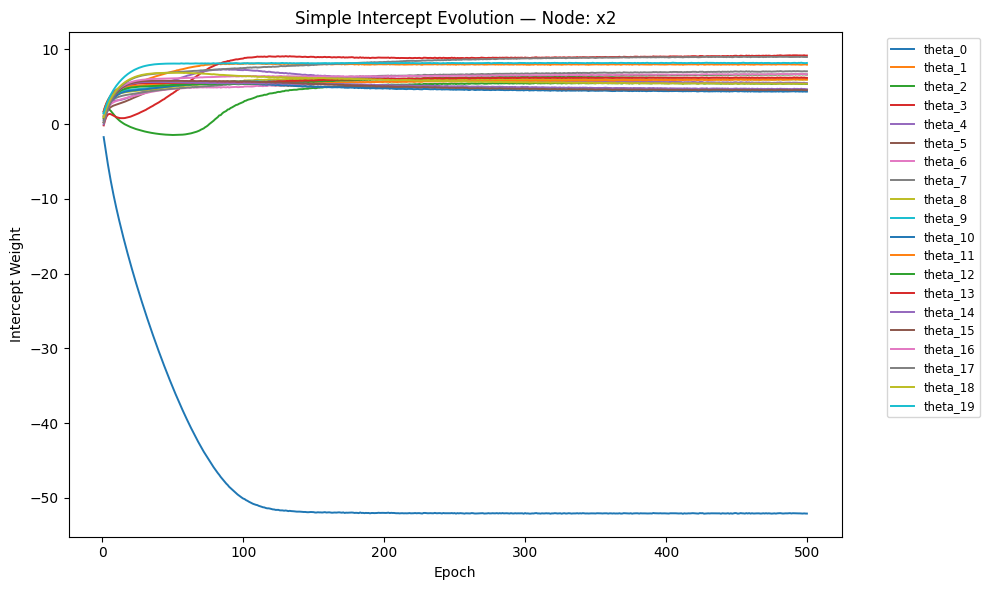

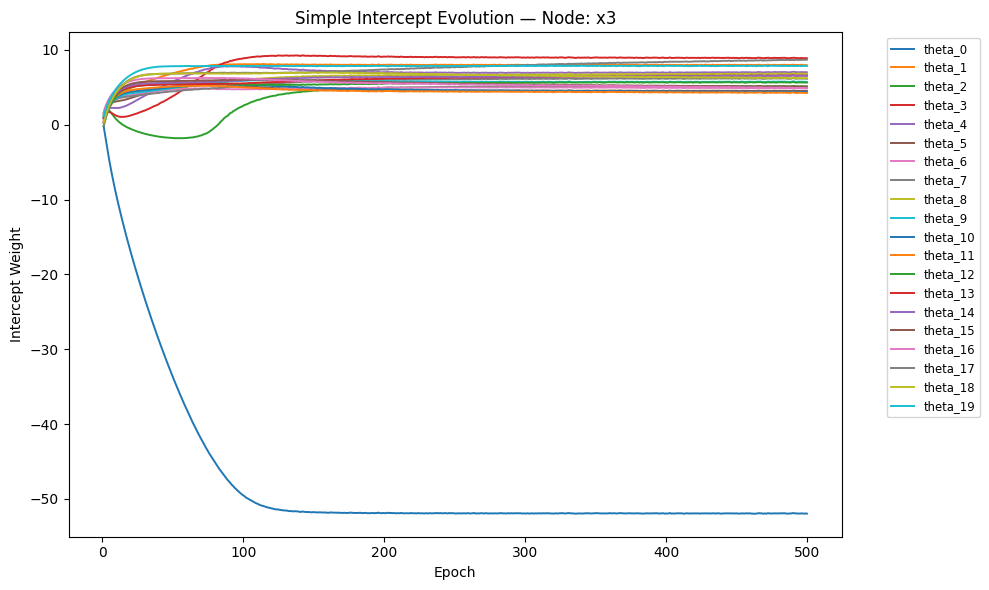

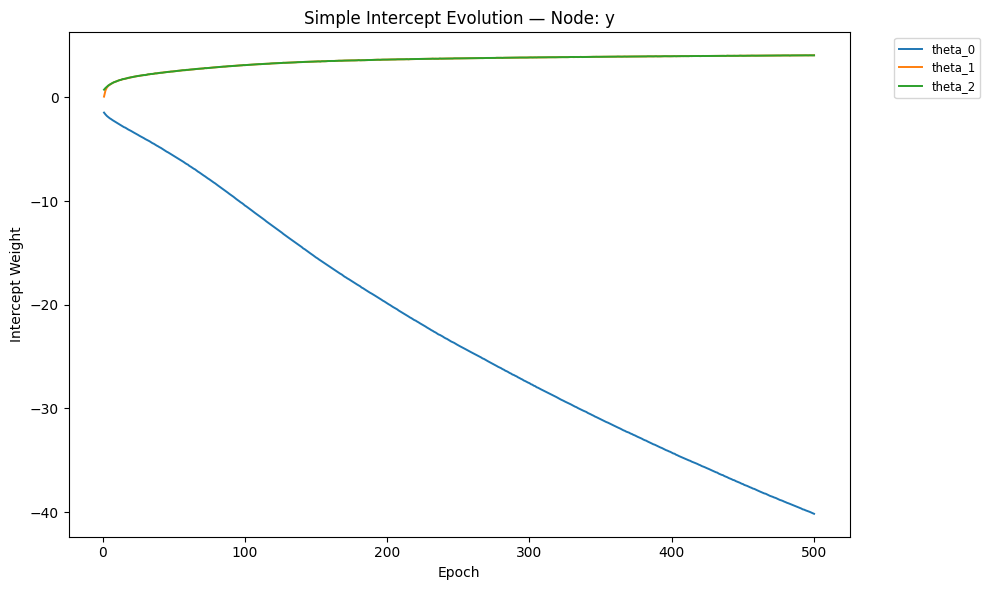

In [15]:
td_model.plot_simple_intercepts()

In [17]:
rsamples, latents = td_model.sample()

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x3/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/y/sampling

----*----------*-------------*--------Sample Node: x ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x from standard logistic distribution
[WARNING] target_col 'x' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.10it/s]

[INFO] Completed sampling for node 'x'

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.27it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.09it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.72it/s]


[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node y from standard logistic distribution
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?
[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


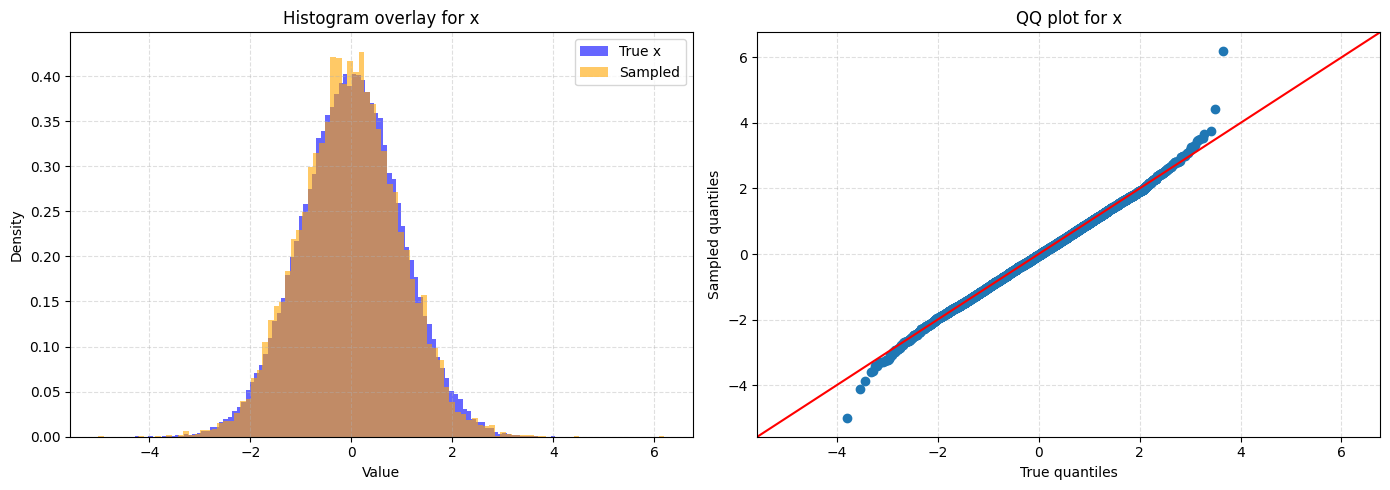

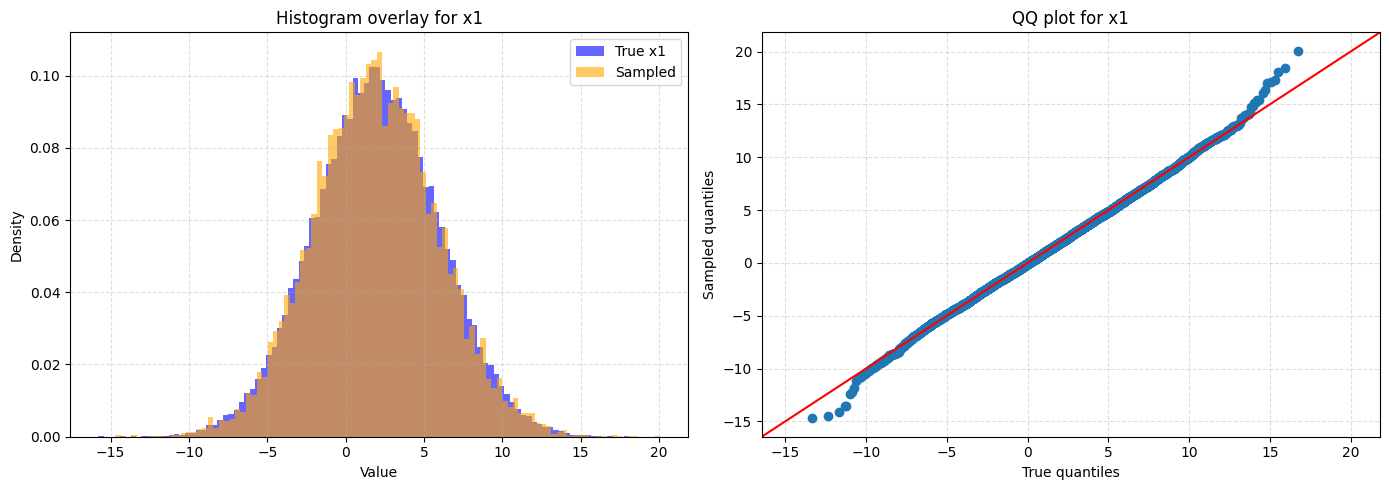

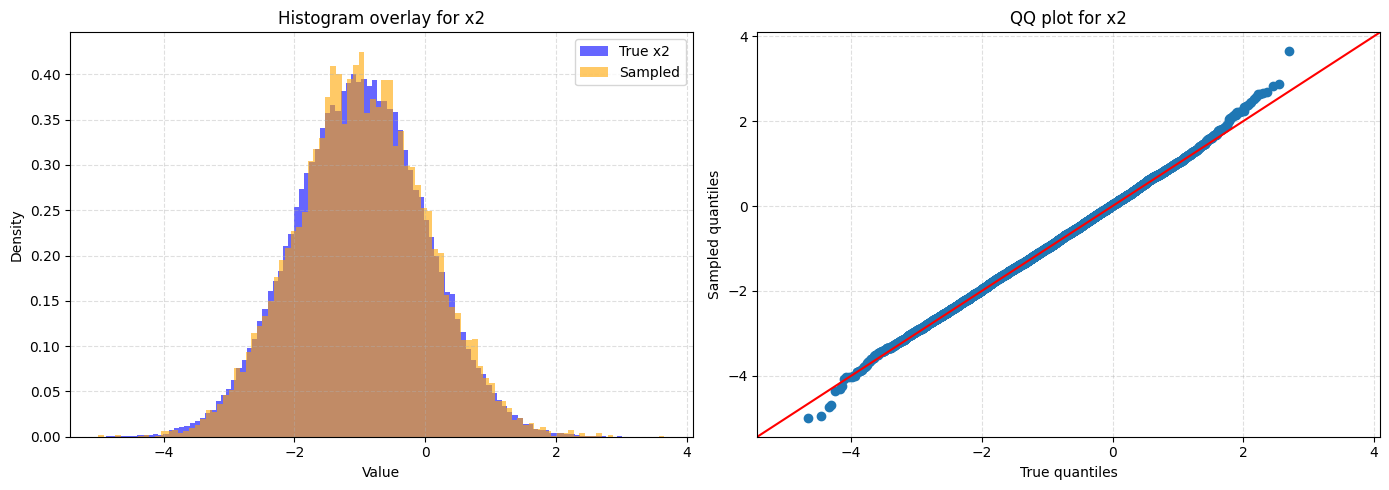

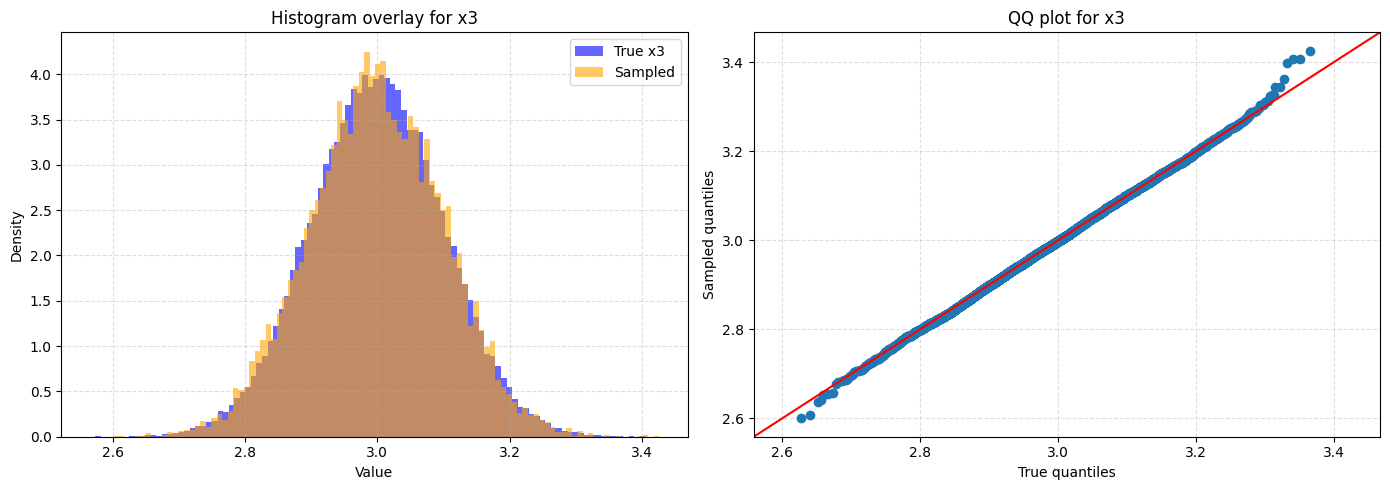

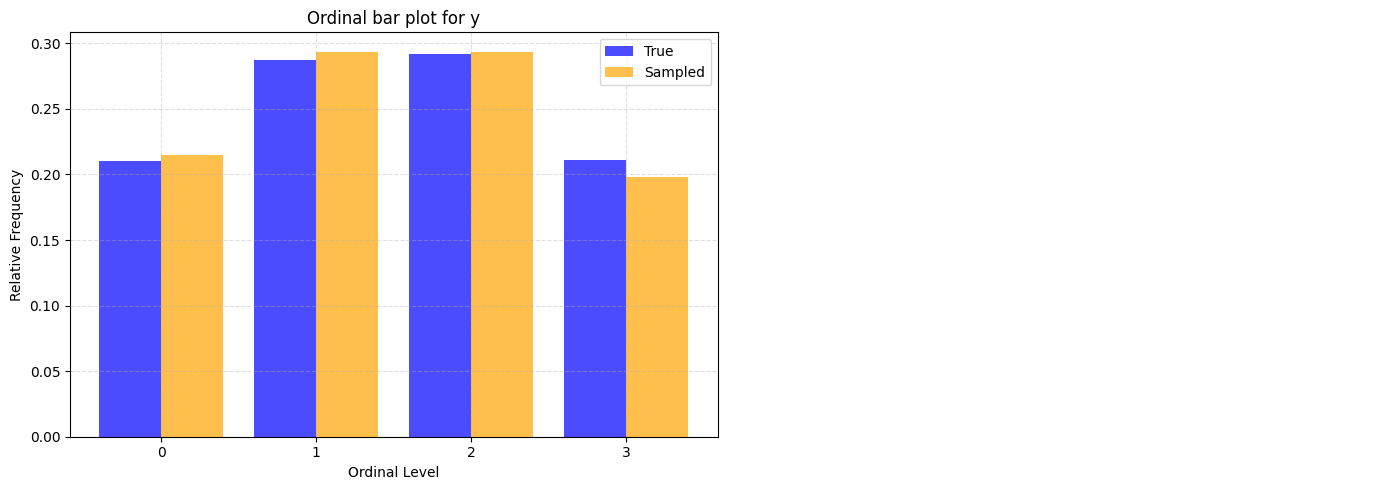

In [18]:
td_model.show_samples_vs_true(train_df)